# *CoastSat*: example at Narrabeen-Collaroy, Australia


This example shows users how to extract time-series of shoreline change over the last 30+ years at their site of interest.
There are five main steps:
1. Retrieval of the satellite images of the region of interest from Google Earth Engine
2. Shoreline extraction at sub-pixel resolution
3. Intersection of the shorelines with cross-shore transects
4. Tidal correction 
5. Time-series post-processing

This software is described in details in the following publications: 
- Shoreline detection:                      https://doi.org/10.1016/j.envsoft.2019.104528
- Accuracy assessment and applications:     https://doi.org/10.1016/j.coastaleng.2019.04.004
- Beach slope estimation:                   https://doi.org/10.1029/2020GL088365

## Initial settings

Refer to the **Installation** section of the README for instructions on how to install the Python packages necessary to run the software, including Google Earth Engine Python API. If that step has been completed correctly, the following packages should be imported without any problem.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

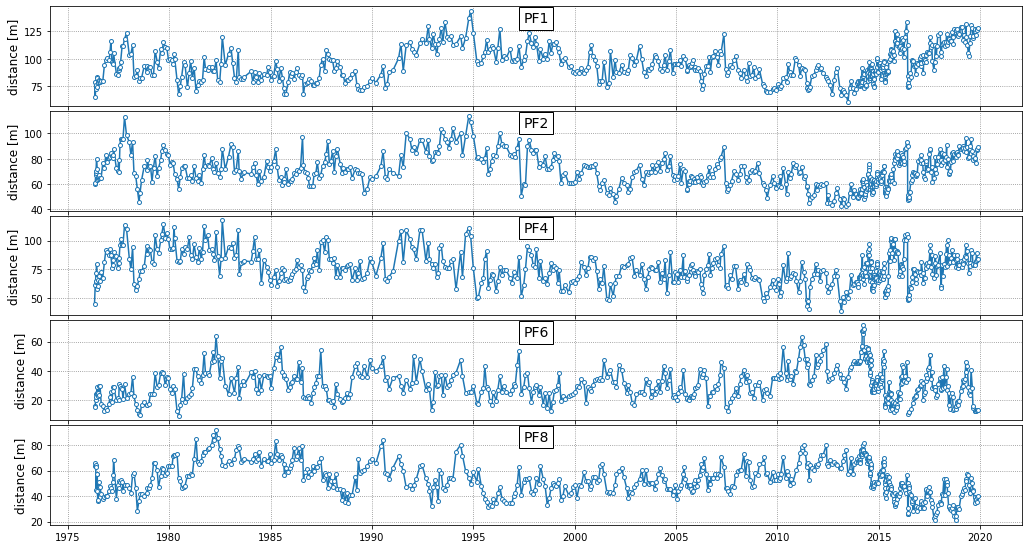

In [10]:
from scipy import interpolate
from scipy import stats
from datetime import timedelta
import pytz
# read the csv file
fp_datasets = os.path.join(os.getcwd(),'examples','Narrabeen_Profiles.csv')
df = pd.read_csv(fp_datasets)
pf_names = list(np.unique(df['Profile ID']))

# select contour level
contour_level = 0.7

# initialise topo_profiles structure
topo_profiles = dict([])
for i in range(len(pf_names)):
     # read dates
    df_pf = df.loc[df['Profile ID'] == pf_names[i]]
    dates_str = df['Date']
    dates_unique = np.unique(dates_str)
    # loop through dates
    topo_profiles[pf_names[i]] = {'dates':[],'chainages':[]}
    for date in dates_unique:
        # extract chainage and elevation for that date
        df_date = df_pf.loc[dates_str == date]
        chainages = np.array(df_date['Chainage'])
        elevations = np.array(df_date['Elevation'])
        if len(chainages) == 0: continue
        # use interpolation to extract the chainage at the contour level
        f = interpolate.interp1d(elevations, chainages, bounds_error=False)
        chainage_contour_level = f(contour_level)
        topo_profiles[pf_names[i]]['chainages'].append(chainage_contour_level)
        date_utc = pytz.utc.localize(datetime.strptime(date,'%Y-%m-%d'))
        topo_profiles[pf_names[i]]['dates'].append(date_utc)

# plot time-series
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(topo_profiles),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(topo_profiles.keys()):
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(topo_profiles[key]['dates'], topo_profiles[key]['chainages'], '-o', ms=4, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  
# save a .pkl file
with open(os.path.join(os.getcwd(), 'examples', 'Narrabeen_ts_07m.pkl'), 'wb') as f:
    pickle.dump(topo_profiles, f)

Now compare the surveys to the satellite-derived shorelines from 1984 loaded previously.

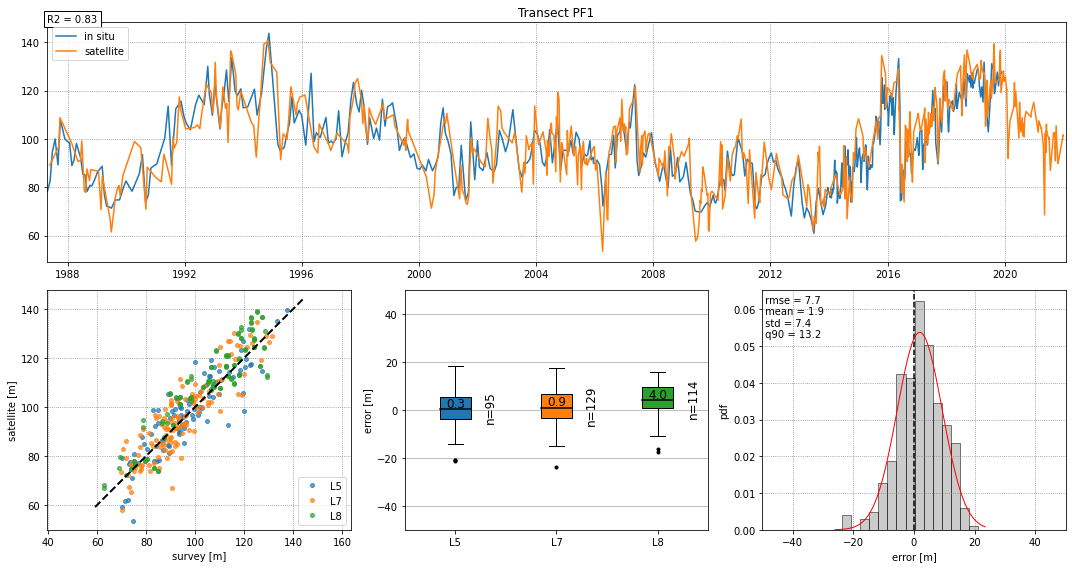

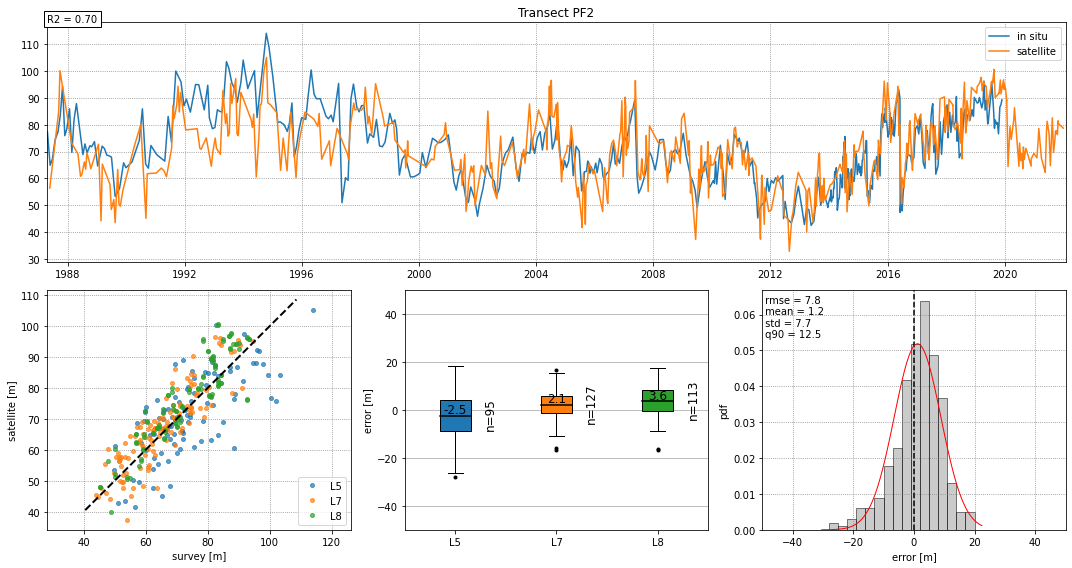

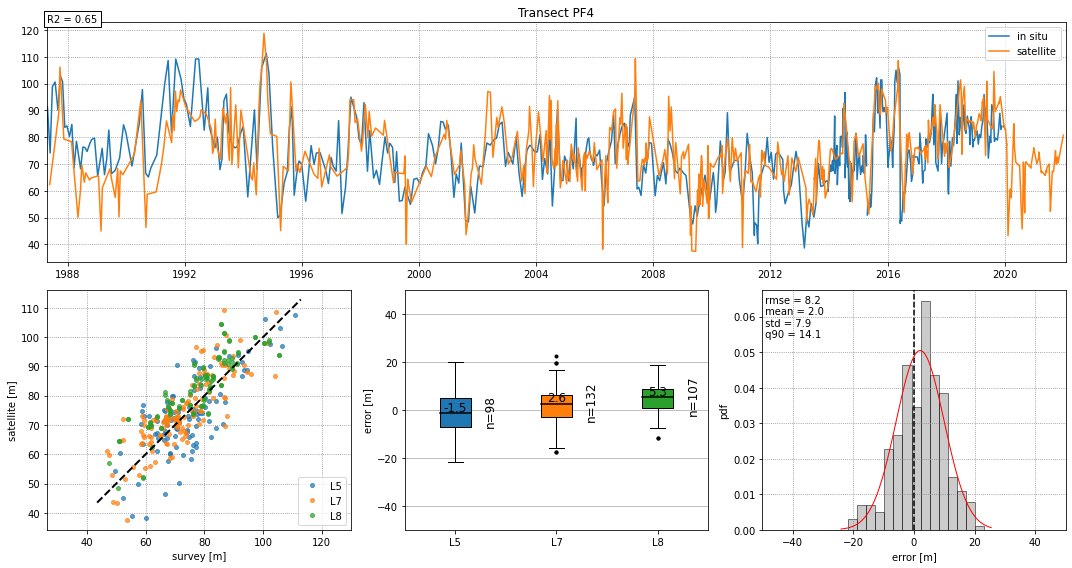

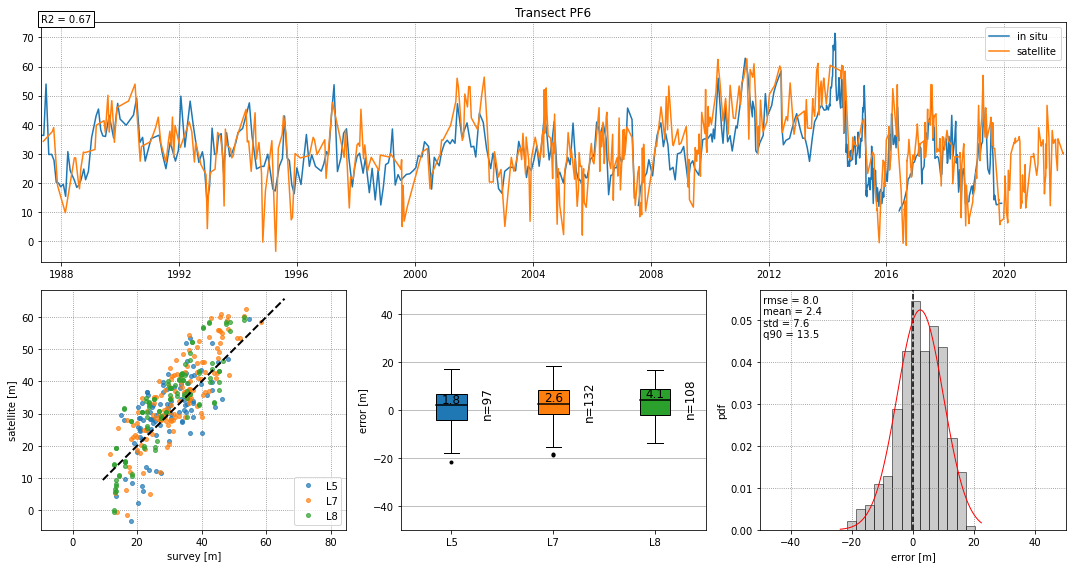

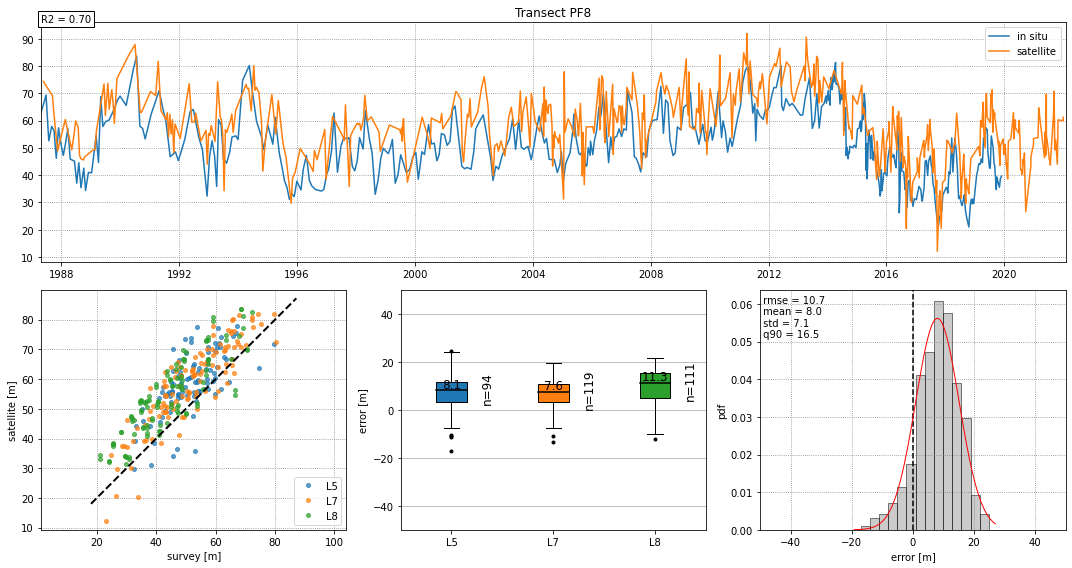

In [29]:
# load survey data
with open(os.path.join(os.getcwd(), 'examples', 'Narrabeen_ts_07m.pkl'), 'rb') as f:
    gt = pickle.load(f)
# change names to mach surveys
for i,key in enumerate(list(cross_distance.keys())):
    key_gt = list(gt.keys())[i]
    cross_distance[key_gt] = cross_distance.pop(key)

# set parameters for comparing the two time-series
sett = {'min_days':3,   # numbers of days difference under which to use nearest neighbour interpolation
        'max_days':10,  # maximum number of days difference to do a comparison
        'binwidth':3,   # binwidth for histogram plotting
        'lims':[-50,50] # cross-shore change limits for plotting purposes
       }

# initialise variables
chain_sat_all = []
chain_sur_all = [] 
satnames_all = []  
for key in cross_distance.keys():
    
    # remove nans
    chainage = cross_distance[key]
    idx_nan = np.isnan(chainage)
    dates_nonans = [output['dates'][k] for k in np.where(~idx_nan)[0]]
    satnames_nonans = [output['satname'][k] for k in np.where(~idx_nan)[0]]
    chain_nonans = chainage[~idx_nan]
    
    chain_sat_dm = chain_nonans
    chain_sur_dm = gt[key]['chainages']
    
    # plot the time-series
    fig= plt.figure(figsize=[15,8], tight_layout=True)
    gs = gridspec.GridSpec(2,3)
    ax0 = fig.add_subplot(gs[0,:])
    ax0.grid(which='major',linestyle=':',color='0.5')
    ax0.plot(gt[key]['dates'], chain_sur_dm, '-',mfc='w',ms=5,label='in situ')
    ax0.plot(dates_nonans, chain_sat_dm,'-',mfc='w',ms=5,label='satellite')
    ax0.set(title= 'Transect ' + key, xlim=[output['dates'][0]-timedelta(days=30),
                                           output['dates'][-1]+timedelta(days=30)])#,ylim=sett['lims'])
    ax0.legend()
    
    # interpolate surveyed data around satellite data
    chain_int = np.nan*np.ones(len(dates_nonans))
    for k,date in enumerate(dates_nonans):
        # compute the days distance for each satellite date 
        days_diff = np.array([ (_ - date).days for _ in gt[key]['dates']])
        # if nothing within 10 days put a nan
        if np.min(np.abs(days_diff)) > sett['max_days']:
            chain_int[k] = np.nan
        else:
            # if a point within 3 days, take that point (no interpolation)
            if np.min(np.abs(days_diff)) < sett['min_days']:
                idx_closest = np.where(np.abs(days_diff) == np.min(np.abs(days_diff)))
                chain_int[k] = float(gt[key]['chainages'][idx_closest[0][0]])
            else: # otherwise, between 3 and 10 days, interpolate between the 2 closest points
                if sum(days_diff > 0) == 0:
                    break
                idx_after = np.where(days_diff > 0)[0][0]
                idx_before = idx_after - 1
                x = [gt[key]['dates'][idx_before].toordinal() , gt[key]['dates'][idx_after].toordinal()]
                y = [gt[key]['chainages'][idx_before], gt[key]['chainages'][idx_after]]
                f = interpolate.interp1d(x, y,bounds_error=True)
                chain_int[k] = float(f(date.toordinal()))
    
    # remove nans again
    idx_nan = np.isnan(chain_int)
    chain_sat = chain_nonans[~idx_nan]
    chain_sur = chain_int[~idx_nan]
    dates_sat = [dates_nonans[k] for k in np.where(~idx_nan)[0]]
    satnames = [satnames_nonans[k] for k in np.where(~idx_nan)[0]]
    chain_sat_all = np.append(chain_sat_all,chain_sat)
    chain_sur_all = np.append(chain_sur_all,chain_sur)
    satnames_all = satnames_all + satnames
    
    # error statistics
    slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat)
    R2 = rvalue**2 
    ax0.text(0,1,'R2 = %.2f'%R2,bbox=dict(boxstyle='square', facecolor='w', alpha=1),transform=ax0.transAxes)
    chain_error = chain_sat - chain_sur
    rmse = np.sqrt(np.mean((chain_error)**2))
    mean = np.mean(chain_error)
    std = np.std(chain_error)
    q90 = np.percentile(np.abs(chain_error), 90)
    
    # 1:1 plot
    ax1 = fig.add_subplot(gs[1,0])
    ax1.axis('equal')
    ax1.grid(which='major',linestyle=':',color='0.5')
    for k,sat in enumerate(list(np.unique(satnames))): 
        idx = np.where([_ == sat for _ in satnames])[0]
        ax1.plot(chain_sur[idx], chain_sat[idx], 'o', ms=4, mfc='C'+str(k),mec='C'+str(k), alpha=0.7, label=sat)
    ax1.legend(loc=4)
    ax1.plot([ax1.get_xlim()[0], ax1.get_ylim()[1]],[ax1.get_xlim()[0], ax1.get_ylim()[1]],'k--',lw=2)
    ax1.set(xlabel='survey [m]', ylabel='satellite [m]')

    # boxplots
    ax2 = fig.add_subplot(gs[1,1])
    data = []
    median_data = []
    n_data = []
    ax2.yaxis.grid()
    for k,sat in enumerate(list(np.unique(satnames))):
        idx = np.where([_ == sat for _ in satnames])[0]
        data.append(chain_error[idx])
        median_data.append(np.median(chain_error[idx]))
        n_data.append(len(chain_error[idx]))
    bp = ax2.boxplot(data,0,'k.', labels=list(np.unique(satnames)), patch_artist=True)
    for median in bp['medians']:
        median.set(color='k', linewidth=1.5)
    for j,boxes in enumerate(bp['boxes']):
        boxes.set(facecolor='C'+str(j))
        ax2.text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=12)
        ax2.text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
    ax2.set(ylabel='error [m]', ylim=sett['lims'])
    
    # histogram
    ax3 = fig.add_subplot(gs[1,2])
    ax3.grid(which='major',linestyle=':',color='0.5')
    ax3.axvline(x=0, ls='--', lw=1.5, color='k')
    binwidth=sett['binwidth']
    bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
    density = plt.hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
    mu, std = stats.norm.fit(chain_error)
    pval = stats.normaltest(chain_error)[1]
    xlims = ax3.get_xlim()
    x = np.linspace(xlims[0], xlims[1], 100)
    p = stats.norm.pdf(x, mu, std)
    ax3.plot(x, p, 'r-', linewidth=1)
    ax3.set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
    str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
    ax3.text(0, 0.98, str_stats,va='top', transform=ax3.transAxes)
    
    # save plot
    fig.savefig(os.path.join(os.getcwd(),'examples','comparison_transect_%s.jpg'%key), dpi=150)


We can also look at the error statistics for all transects:

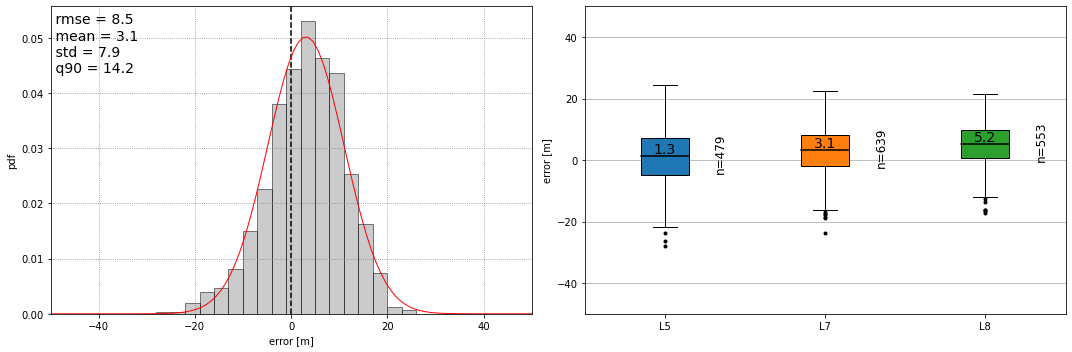

In [33]:
# calculate statistics for all transects together
chain_error = chain_sat_all - chain_sur_all        
slope, intercept, rvalue, pvalue, std_err = stats.linregress(chain_sur, chain_sat) 
R2 = rvalue**2
rmse = np.sqrt(np.mean((chain_error)**2))
mean = np.mean(chain_error)
std = np.std(chain_error)
q90 = np.percentile(np.abs(chain_error), 90)

fig,ax = plt.subplots(1,2,figsize=(15,5), tight_layout=True)
# histogram
ax[0].grid(which='major',linestyle=':',color='0.5')
ax[0].axvline(x=0, ls='--', lw=1.5, color='k')
binwidth=sett['binwidth']
bins = np.arange(min(chain_error), max(chain_error) + binwidth, binwidth)
density = ax[0].hist(chain_error, bins=bins, density=True, color='0.6', edgecolor='k', alpha=0.5)
mu, std = stats.norm.fit(chain_error)
pval = stats.normaltest(chain_error)[1]
xlims = ax3.get_xlim()
x = np.linspace(xlims[0], xlims[1], 100)
p = stats.norm.pdf(x, mu, std)
ax[0].plot(x, p, 'r-', linewidth=1)
ax[0].set(xlabel='error [m]', ylabel='pdf', xlim=sett['lims'])   
str_stats = ' rmse = %.1f\n mean = %.1f\n std = %.1f\n q90 = %.1f' % (rmse, mean, std, q90) 
ax[0].text(0, 0.98, str_stats,va='top', transform=ax[0].transAxes,fontsize=14)

# boxplot
data = []
median_data = []
n_data = []
ax[1].yaxis.grid()
for k,sat in enumerate(list(np.unique(satnames_all))):
    idx = np.where([_ == sat for _ in satnames_all])[0]
    data.append(chain_error[idx])
    median_data.append(np.median(chain_error[idx]))
    n_data.append(len(chain_error[idx]))
bp = ax[1].boxplot(data,0,'k.', labels=list(np.unique(satnames_all)), patch_artist=True)
for median in bp['medians']:
    median.set(color='k', linewidth=1.5)
for j,boxes in enumerate(bp['boxes']):
    boxes.set(facecolor='C'+str(j))
    ax[1].text(j+1,median_data[j]+1, '%.1f' % median_data[j], horizontalalignment='center', fontsize=14)
    ax[1].text(j+1+0.35,median_data[j]+1, ('n=%.d' % int(n_data[j])), ha='center', va='center', fontsize=12, rotation='vertical')
ax[1].set(ylabel='error [m]', ylim=sett['lims']);
fig.savefig(os.path.join(os.getcwd(),'examples','comparison_all_transects.jpg'), dpi=150)